# ESN predictions on MJO without TDE

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [13]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, JLD2

In [3]:
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header);

pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"]
amp = data[!, "PC1+PC2 amplitude"];

In [4]:
# take same values as for tde to make comparable
train_size= 10000
val_size= 2000
test_size = length(pc1) - train_size - val_size;

## train ESNs

In [5]:
data= Matrix(transpose([pc1 pc2]))

2×12603 Matrix{Float64}:
  0.12526   0.18542   0.2396   0.27446  …  -0.40529  -0.33531  -0.37026
 -0.06945  -0.04887  -0.03933  0.0199      -0.40887  -0.38871  -0.34477

In [6]:
pc1_train = data[1:1, 1:train_size]
pc1_val = data[1:1, train_size+1:train_size+val_size]
pc1_test = data[1:1, train_size+val_size+1:train_size+val_size+test_size];

pc2_train = data[2:2, 1:train_size]
pc2_val = data[2:2, train_size+1:train_size+val_size]
pc2_test = data[2:2, train_size+val_size+1:train_size+val_size+test_size];

In [7]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn_pc1, W_out_pc1, val_loss_pc1 = enso_project.cross_validate_esn(pc1_train, pc1_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.4551650128246
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.1809479522246
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1636.359037249957
enso_project.ESNHyperparams(500, 1.0, 0.1, 0.1, 0.0)
Validation loss = 1580.871869358186


(ESN(1 => 500), OutputLayer successfully trained with output size: 1, 1580.871869358186)

In [8]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn_pc2, W_out_pc2, val_loss_pc2 = enso_project.cross_validate_esn(pc2_train, pc2_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1268.4801431366027
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1267.6585290526114
enso_project.ESNHyperparams(1000, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1242.7030851223126
enso_project.ESNHyperparams(500, 1.0, 0.5, 0.1, 1.0e-5)
Validation loss = 1227.7113264051359


(ESN(1 => 500), OutputLayer successfully trained with output size: 1, 1227.7113264051359)

## evaluate predictions

In [9]:
prediction_D1 = enso_project.esn_eval_pred(esn_pc1, W_out_pc1, pc1_test)
prediction_D2 = enso_project.esn_eval_pred(esn_pc2, W_out_pc2, pc2_test);

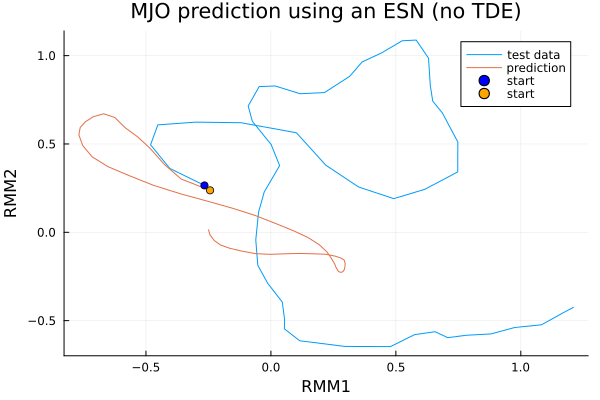

In [11]:
plot(pc1_test[1,1:50], pc2_test[1,1:50], label="test data", xlabel="RMM1",ylabel="RMM2", title="MJO prediction using an ESN (no TDE)")
plot!(prediction_D1[1:50], prediction_D2[1:50], label="prediction")
scatter!([pc1_test[1,1]], [pc2_test[1,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction_D1[1]], [prediction_D2[1]], label="start", color=:orange, marker=:circle, markersize=4)
#scatter!([pc1_test[1,50]], [pc2_test[1,50]], label="t=50", color=:black, marker=:circle, markersize=4)
#scatter!([prediction_D1[50]], [prediction_D2[50]], label="t=50", color=:black, marker=:circle, markersize=4)
#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_prediction_no_tde")

In [14]:
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/esn_saves/mjo_no_tde_pc1.jld2" esn_pc1=esn_pc1
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/esn_saves/mjo_no_tde_pc1_W.jld2" W_out_pc1=W_out_pc1

In [15]:
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/esn_saves/mjo_no_tde_pc2.jld2" esn_pc2=esn_pc2
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/esn_saves/mjo_no_tde_pc2_W.jld2" W_out_pc2=W_out_pc2